# Fine Tuning BERT
We want to predict the lexical proficiency of the author of a text.

We start with a pre-trained BERT language model and feed it labelled examples.

## Modules and Globals

In [8]:
# Files
import os

DATA_DIR = 'data/'

# Feedback
from tqdm import tqdm # progress bars
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Digits and Strings
import numpy as np
import pandas as pd
import re # regex

# Util
from itertools import product # Cartesian product

# Huggingface
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer

MODEL_NAME = 'bert-base-uncased'
TOKENIZER = BertTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Scale some vector to floating point values between -1 and 1
SCALER = MinMaxScaler(feature_range=(-1, 1))

# PyTorch
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Data
There are a lot of options to experiment with here, so let's manage them with a class.

In [9]:
class icnale_data:
    '''
    Takes a pandas dataframe and optionally prepocesses it a bit.
    icnale_data.make() will return a Huggingface Dataset object.
    Details are ICNALE specific, of course.
    '''
    
    def __init__(self, df):
        df['label'] = df['VST'] # Huggingface calls it a label
        df['label'] = SCALER.fit_transform(df[['label']])

        self.df = df[['label', 'text']]

    def tokenize(self, batch):
        # Turns text into a series of numbers that BERT can understand.
        return TOKENIZER(batch['text'],
                         padding="max_length",
                         truncation=True,
                         max_length=TOKENIZER.max_model_input_sizes[MODEL_NAME])

    def make(self):
        # Let's manage our data with Huggingface's Dataset class
        dataset = Dataset.from_pandas(self.df.reset_index(drop=True))
        dataset = dataset.map(self.tokenize, batched=True, batch_size=1)
        dataset = dataset.remove_columns('text')

        # some pretrained models do not use token_type_ids
        columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label']
        columns = list(set(columns).intersection(dataset.column_names))
        dataset.set_format(type='torch', columns=columns, device=DEVICE)
    
        return dataset

both_prompts_but_no_test = DATA_DIR + 'all_train.csv'
test_smk_path = DATA_DIR + 'smk_test.csv'

train, valid = train_test_split(pd.read_csv(both_prompts_but_no_test),
                                test_size=.2,
                                random_state=42)

test = pd.read_csv(test_smk_path)

datadict = DatasetDict(
    {
        'train': icnale_data(train).make(),
        'valid': icnale_data(valid).make(),
        'test': icnale_data(test).make(),
    }
)

  0%|          | 0/3744 [00:00<?, ?ba/s]

  0%|          | 0/936 [00:00<?, ?ba/s]

  0%|          | 0/520 [00:00<?, ?ba/s]

## Hyperparameter Search Configuration
We follow Devlin et al.'s recommendations quite closely here. After some experimentation with freezing layers and other approaches, we found that the original BERT paper made appropriate suggestions for this dataset and task.

In [10]:
BATCH_SIZE = 16 # apriori selected due to GPU memory limitations.

def model_init():
    return BertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=1)

def compute_metrics(pred):
    return {'r2': r2_score(pred.label_ids, pred.predictions)}

args = TrainingArguments(
    output_dir='bin',
    evaluation_strategy='epoch',
    learning_rate=3e-05, # Finetuned
    weight_decay=0.01, # Devlin et al. suggested
    num_train_epochs=3, # Finetuned
    seed=1, # apriori
    logging_strategy='epoch',
    save_strategy='no',
    fp16=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    load_best_model_at_end=False,
)

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=datadict['train'],
    eval_dataset=datadict['valid'],
    tokenizer=TOKENIZER,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /home/jovyan/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /home/jovyan/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/jovyan/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense

## Hyperparamter Search Execution
The following hyperparameter search takes a few hours. You probably want to skip the next two cells.

In [11]:
# in case the process gets interrupted, it would be nice to keep some results
import json
import logging
logfile = 'bin/hp_bert.log'
logging.basicConfig(level=logging.INFO,
                    filename=logfile,
                    format='%(asctime)s -- %(message)s')

param_grid = {
    "learning_rate": [2e-5, 3e-5, 5e-5], # Range suggested by Devlin et al.
    "num_train_epochs": [2, 3, 4] # Range suggested by Devlin et al.
}

logging.info('New Hyperparameter Search, minmaxscaler -1 to 1')
logging.info(json.dumps(param_grid))

# Since we have 2 settings with 3 values each, we will finetune 9 times
cartesian_product = [dict(zip(param_grid.keys(), values)) for 
                     values in product(*param_grid.values())]

for i, params in enumerate(cartesian_product):
    for k, v in params.items():
        setattr(trainer.args, k, v)

    start = time.time()
    trainer.train()
    time_elapsed = time.time() - start

    preds = trainer.predict(datadict['valid'])
    r2 = r2_score(preds.label_ids, preds.predictions)

    print(', '.join([f'{k}: {v}' for k, v in params.items()]), end=' ')
    print(f'--> R-squared: {r2:.3f}')
    print(f'Time elapsed: {time_elapsed:.0f} seconds')

    params['trial'] = i
    params['score'] = r2
    params['seconds'] = time_elapsed

    logging.info(json.dumps(params))

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

Epoch,Training Loss,Validation Loss,R2
1,0.148900,0.172864,0.242981
2,0.112100,0.146480,0.358522


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

learning_rate: 2e-05, num_train_epochs: 2 --> R-squared: 0.359
Time elapsed: 109 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,R2
1,0.145600,0.154919,0.321567
2,0.115700,0.153389,0.328267
3,0.088900,0.146131,0.360050


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



learning_rate: 2e-05, num_train_epochs: 3 --> R-squared: 0.360
Time elapsed: 162 seconds


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/jovyan/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequ

Epoch,Training Loss,Validation Loss,R2
1,0.152100,0.154535,0.323247
2,0.118000,0.151573,0.336219
3,0.088600,0.145159,0.364308
4,0.065500,0.149650,0.344641


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

learning_rate: 2e-05, num_train_epochs: 4 --> R-squared: 0.345
Time elapsed: 215 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,R2
1,0.147800,0.153417,0.328144
2,0.104800,0.147146,0.355608


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

learning_rate: 3e-05, num_train_epochs: 2 --> R-squared: 0.356
Time elapsed: 108 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,R2
1,0.153000,0.160852,0.295585
2,0.113000,0.161412,0.293130
3,0.080900,0.140901,0.382954


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

learning_rate: 3e-05, num_train_epochs: 3 --> R-squared: 0.383
Time elapsed: 162 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,R2
1,0.157600,0.197320,0.135879
2,0.116700,0.182483,0.200854
3,0.079700,0.147495,0.354079
4,0.047000,0.153873,0.326148


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

learning_rate: 3e-05, num_train_epochs: 4 --> R-squared: 0.326
Time elapsed: 215 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,R2
1,0.159200,0.161386,0.293246
2,0.109800,0.148169,0.351125


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

learning_rate: 5e-05, num_train_epochs: 2 --> R-squared: 0.351
Time elapsed: 108 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,R2
1,0.149500,0.196214,0.140723
2,0.110300,0.149624,0.344754
3,0.063000,0.150235,0.342078


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

learning_rate: 5e-05, num_train_epochs: 3 --> R-squared: 0.342
Time elapsed: 161 seconds


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,R2
1,0.151900,0.168206,0.263378
2,0.115900,0.144970,0.365136
3,0.065900,0.151054,0.338494
4,0.031900,0.157674,0.309502


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 936
  Batch size = 16


learning_rate: 5e-05, num_train_epochs: 4 --> R-squared: 0.310
Time elapsed: 215 seconds


In [21]:
with open(logfile) as f:
    param_results = [json.loads(line.split('--')[1].strip())
                     for line in f.readlines()[-9:]]

results_df = pd.DataFrame.from_records(param_results, index='trial')
results_df.to_csv('bin/bert_gridsearch.csv')

In [22]:
# Choose best hyperparameters, train model
setattr(trainer.args,  "learning_rate", 3e-5)
setattr(trainer.args,  "num_train_epochs", 3)

trainer.train()
trainer.save_model('bin/fine_tuned_VST_bert_min_max_scaler')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights fil

Epoch,Training Loss,Validation Loss,R2
1,0.149100,0.158636,0.305288
2,0.109100,0.147768,0.352884
3,0.075500,0.147852,0.352513


***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16
***** Running Evaluation *****
  Num examples = 936
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to bin/fine_tuned_VST_bert_min_max_scaler
Configuration saved in bin/fine_tuned_VST_bert_min_max_scaler/config.json
Model weights saved in bin/fine_tuned_VST_bert_min_max_scaler/pytorch_model.bin
tokenizer config file saved in bin/fine_tuned_VST_bert_min_max_scaler/tokenizer_config.json
Special tokens file saved in bin/fine_tuned_VST_bert_min_max_scaler/special_tokens_map.json


## Load the finetuned model and test it


In [23]:
model = BertForSequenceClassification.from_pretrained('bin/fine_tuned_VST_bert_min_max_scaler/').to(DEVICE)
loader = torch.utils.data.DataLoader(datadict['test'], batch_size=BATCH_SIZE)
labels = loader.dataset['label'].cpu().numpy().reshape(-1, 1)
preds = np.empty((loader.dataset.num_rows, 1))
for i, batch in tqdm(enumerate(loader)):
    st = i*loader.batch_size
    with torch.no_grad():
        logits = model(batch['input_ids'],
                       batch['attention_mask']).logits
    preds[st:st+len(batch['label'])] = logits.squeeze().cpu().numpy().reshape(-1, 1)

loading configuration file bin/fine_tuned_VST_bert_min_max_scaler/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "regression",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file bin/fine_tuned_VST_bert_min_max_scaler/pytorch_model.bin
All model checkpoint weights we

In [29]:
# Let's inverse scale so that MAE and RMSE will approximate original (VST) units
scaled_labels = SCALER.inverse_transform(labels)

# Raise error if the scaled labels (rounded) do not equal original VST scores.
assert np.array_equal(np.around(scaled_labels), test[['VST']].to_numpy()) 

scaled_preds = SCALER.inverse_transform(preds)

print(f'RMSE: {mean_squared_error(scaled_labels, scaled_preds, squared=False):.3f}')
print(f'MAE:  {mean_absolute_error(scaled_labels, scaled_preds):.3f}')
print(f'R2:   {r2_score(scaled_labels, scaled_preds):.3f}')

RMSE: 7.127
MAE:  5.438
R2:   0.321


## Plot both Gridsearches

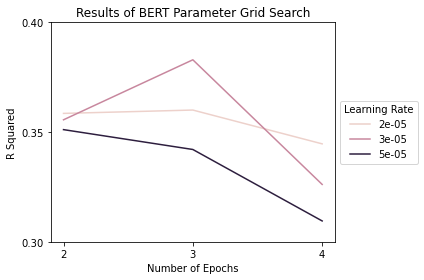

In [34]:
bert_gs = pd.read_csv('bin/bert_gridsearch.csv')
ax = sns.lineplot(data=bert_gs, x='num_train_epochs', y='score', hue='learning_rate')

Y_SCALE = np.linspace(.15, .40, num=6)
ax.set_title('Results of BERT Parameter Grid Search')
ax.set_ylabel('R Squared')
ax.set_xlabel('Number of Epochs')
# ax.set(ylim=(None, .35))
ax.set_yticks(np.linspace(.30, .40, num=3))
ax.set_xticks([2, 3, 4])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Learning Rate')
figure = ax.get_figure()
plt.tight_layout()
plt.show()   
figure.savefig('figs/bert_gridsearch.png', dpi=300)

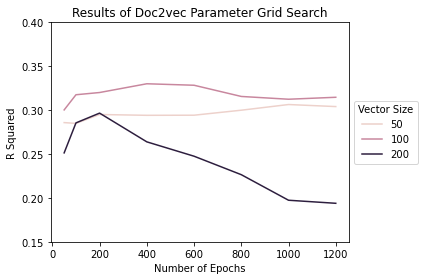

In [35]:
d2v_gs = pd.read_csv('bin/d2v_gridsearch.csv')
ax = sns.lineplot(data=d2v_gs, x='epochs', y='score', hue='vector_size')
ax.set_title('Results of Doc2vec Parameter Grid Search')
ax.set_ylabel('R Squared')
ax.set_xlabel('Number of Epochs')
ax.set_yticks(np.linspace(.15, .40, num=6))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Vector Size')
figure = ax.get_figure()
plt.tight_layout()
plt.show()   
figure.savefig('figs/d2v_gridsearch.png', dpi=300)